In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import xgboost as xgb
import scooby
import torch
import torch.nn as nn

from scipy.signal import filtfilt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import train_test_split

# from dataset import *
# from model import *
# from train import *
# from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Wireline input

In [3]:
# Load the training data
train_data = pd.read_csv('../../../labs/data/train.csv', sep=';')
train_data['WELL'] = train_data['WELL'].astype('category').cat.codes

# Load the validing data
valid_data = pd.read_csv('../../../labs/data/leaderboard_test_features.csv', sep=';')
valid_data['WELL'] = valid_data['WELL'].astype('category').cat.codes

train_data = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']].copy().dropna()
valid_data = valid_data[~np.isnan(valid_data.DTS.values)][['WELL', 'DEPTH_MD','CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']].copy().dropna()

train_data = train_data.mask(train_data>train_data.quantile(0.995), train_data.quantile(0.995), axis=1)
valid_data = valid_data.mask(valid_data>valid_data.quantile(0.995), valid_data.quantile(0.995), axis=1)

# Select input
X_train = train_data[['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC','WELL']].copy()
y_train = train_data[['DTS', 'WELL']].copy()

X_valid = valid_data[['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC','WELL']].copy()
y_valid = valid_data[['DTS', 'WELL']].copy()

# Tranform RES logs
# X_train['RSHA']=np.log(X_train.RSHA.values)
# X_valid['RSHA']=np.log(X_valid.RSHA.values)
# X_train['RMED']=np.log(X_train.RMED.values)
# X_valid['RMED']=np.log(X_valid.RMED.values)
X_train['RDEP']=np.log(X_train.RDEP.values)
X_valid['RDEP']=np.log(X_valid.RDEP.values)

# Numpy to PyTorch Dataset

In [4]:
# Define Train Set
X_train = torch.from_numpy(X_train.to_numpy()).float().view(-1,X_train.shape[1])
y_train = torch.from_numpy(y_train.to_numpy()).float().view(-1,y_train.shape[1])
train_dataset = TensorDataset(X_train, y_train)

# Define Test Set
X_valid = torch.from_numpy(X_valid.to_numpy()).float().view(-1,X_valid.shape[1])
y_valid = torch.from_numpy(y_valid.to_numpy()).float().view(-1,y_valid.shape[1])
valid_dataset = TensorDataset(X_valid, y_valid)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
train_loader = DataLoader(train_dataset, batch_size=X_train.size(0), shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=X_valid.size(0), shuffle=False)

torch.save(train_loader, '../data/train_loader.pth')    
torch.save(valid_loader, '../data/valid_loader.pth')   

# Statistical Information

In [6]:
# Wells in number
print('The number of original training well are {}.'.format(len(np.unique(pd.read_csv('../../../labs/data/train.csv', sep=';')['WELL'].values))))
print('The number of trainig wells are {}.'.format(len(np.unique(train_data['WELL'].values))))
print('The number of original validing well are {}.'.format(len(np.unique(pd.read_csv('../../../labs/data/leaderboard_test_features.csv', sep=';')['WELL'].values))))
print('The number of validing wells are {}.'.format(len(np.unique(valid_data['WELL'].values))))

# Each corresponding well length
print("Each well contains: ")
for i in np.unique(train_data['WELL'].values):
    print(len(train_data[train_data['WELL']==i]))

The number of original training well are 98.
The number of trainig wells are 28.
The number of original validing well are 10.
The number of validing wells are 6.
Each well contains: 
3551
1186
3639
3210
1654
2979
2091
10030
4950
241
3956
2171
8678
2043
3569
13222
1828
12687
3389
2175
2196
8622
5079
15747
2115
4277
4930
1538


# Plotting

In [7]:
def plot_wirelines(data_plot):
    fig, ax = plt.subplots(figsize=(15,8))#Set up the plot axes
    ax1 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan = 1, sharey = ax1)
    ax4 = plt.subplot2grid((1,6), (0,3), rowspan=1, colspan = 1, sharey = ax1)
    ax5 = ax3.twiny() 

    #Twins the y-axis for the density track with the neutron track
    ax6 = plt.subplot2grid((1,6), (0,4), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax12 = ax3.twiny()
    ax12.xaxis.set_visible(False)
    ax13 = ax4.twiny()
    ax13.xaxis.set_visible(False)
    ax14 = ax6.twiny()
    ax14.xaxis.set_visible(False)

    # Gamma Ray track
    ax1.plot("GR", "DEPTH_MD", data=data_plot, color = "green", linewidth = 0.5)
    ax1.set_xlabel("Gamma")
    ax1.xaxis.label.set_color("green")
    ax1.set_xlim(0, 200)
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')
    ax1.set_xticks([0, 50, 100, 150, 200])

    # Resistivity track
    ax2.plot("RDEP", "DEPTH_MD", data=data_plot, color = "red", linewidth = 0.5)
    ax2.set_xlabel("Resistivity - Deep")
    ax2.set_xlim(0.2, 2000)
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red")
    ax2.spines["top"].set_edgecolor("red")
    ax2.set_xticks([0.1, 1, 10, 100, 1000])
    ax2.semilogx()

    # Density track
    ax3.plot("RHOB", "DEPTH_MD", data=data_plot, color = "red", linewidth = 0.5)
    ax3.set_xlabel("Density")
    ax3.set_xlim(1.95, 2.95)
    ax3.xaxis.label.set_color("red")
    ax3.tick_params(axis='x', colors="red")
    ax3.spines["top"].set_edgecolor("red")
    ax3.set_xticks([1.95, 2.45, 2.95])

    # Sonic track
    ax4.plot("DTC", "DEPTH_MD", data=data_plot, color = "purple", linewidth = 0.5)
    ax4.set_xlabel("Sonic - Compressional")
    ax4.set_xlim(140, 40)
    ax4.xaxis.label.set_color("purple")
    ax4.tick_params(axis='x', colors="purple")
    ax4.spines["top"].set_edgecolor("purple")

    # Neutron track placed ontop of density track
    ax5.plot("NPHI", "DEPTH_MD", data=data_plot, color = "blue", linewidth = 0.5)
    ax5.set_xlabel('Neutron')
    ax5.xaxis.label.set_color("blue")
    ax5.set_xlim(.5, 0)
    ax5.tick_params(axis='x', colors="blue")
    ax5.spines["top"].set_position(("axes", 1.08))
    ax5.spines["top"].set_visible(True)
    ax5.spines["top"].set_edgecolor("blue")
    # ax5.set_xticks([45,  15, -15])

    # Caliper track
    ax6.plot("CALI", "DEPTH_MD", data=data_plot, color = "black", linewidth = 0.5)
    ax6.set_xlabel("Caliper")
    ax6.set_xlim(8, 10)
    ax6.xaxis.label.set_color("black")
    ax6.tick_params(axis='x', colors="black")
    ax6.spines["top"].set_edgecolor("black")
    # ax6.fill_betweenx(well_nan.index, 8.5, well["CALI"], facecolor='yellow')
    # ax6.set_xticks([6,  11, 16])

    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax3, ax4, ax6]:
        # ax.set_ylim(4500, 3500)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
    for ax in [ax2, ax3, ax4, ax6]:
        plt.setp(ax.get_yticklabels(), visible = False)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    plt.show()

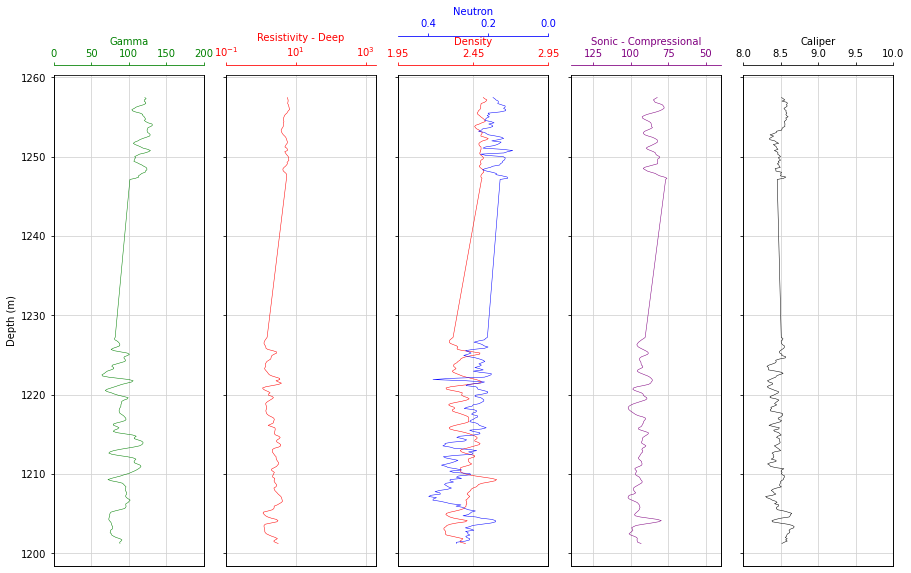

In [8]:
data_plot = train_data[train_data.WELL==55]#np.unique(train_data.WELL.values)[0]]
plot_wirelines(data_plot)

In [9]:
# Sanity check on each well length
print("Each well contains: ")
for i in np.unique(valid_data['WELL'].values):
    print(len(valid_data[valid_data['WELL']==i]))

Each well contains: 
2971
4063
11990
6194
13092
4262


# Wireline Segmentation/Splitting

In [13]:
# Naive way to segment the wireline data based on specific sequence length
seq_len = 512
df_train = train_data[train_data['WELL']==7][:seq_len]
for i in np.unique(train_data.WELL.values):
    sz = len(train_data[train_data['WELL']==i])//seq_len
    for j in range(sz):
        df_train_seq = train_data[train_data['WELL']==i][j*seq_len:(j+1)*seq_len]
        df_train = df_train.append(df_train_seq, ignore_index=True)
    
    df_train = df_train.append(train_data[train_data['WELL']==i][-seq_len:], ignore_index=True)

df_valid = valid_data[valid_data['WELL']==1][:seq_len]
for i in np.unique(valid_data.WELL.values):
    sz = len(valid_data[valid_data['WELL']==i])//seq_len
    for j in range(sz):
        df_valid_seq = valid_data[valid_data['WELL']==i][j*seq_len:(j+1)*seq_len]
        df_valid = df_valid.append(df_valid_seq, ignore_index=True)
    
    df_valid = df_valid.append(valid_data[valid_data['WELL']==i][-seq_len:], ignore_index=True)

In [14]:
# Removing less than sequence length well
for i in np.unique(train_data.WELL.values):
    if len(df_train[df_train.WELL==i])%seq_len!=0:
        print(i, len(train_data[train_data.WELL==55]))
        df_train = df_train.drop(df_train[df_train.WELL==i].index)

55 241


In [24]:
df_train

,WELL,DEPTH_MD,CALI,RDEP,RHOB,GR,NPHI,PEF,DTC
0,7,2138.789599,9.172491,1.131711,2.269236,70.982765,0.509389,8.824317,81.404381
1,7,2138.941599,9.502436,1.135949,2.420680,65.994087,0.366960,7.678865,80.295700
2,7,2139.093599,9.692913,1.139201,2.331994,66.565147,0.289407,6.559052,79.370796
3,7,2139.245599,9.890905,1.143700,2.328588,67.719505,0.269194,7.105228,79.169151
4,7,2139.397599,10.107127,1.099546,2.321023,66.386986,0.292627,7.869129,79.796066
...,...,...,...,...,...,...,...,...,...
138476,97,3159.584400,8.420886,0.831749,2.327454,30.693535,0.165856,6.603628,102.210472
138477,97,3159.736400,8.428133,0.854277,2.365172,32.359882,0.174907,6.987558,102.637398
138478,97,3159.888400,8.409408,0.895604,2.386400,36.232948,0.182118,7.163559,102.694748
138479,97,3160.040400,8.400051,0.917150,2.362845,41.044968,0.176795,7.281550,102.095696


# Wrapping into PyTorch Dataloader

In [63]:
# Wrap in PyTorch dataset
class WirelineDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    def __getitem__(self, idx):

        well = np.unique(self.data.WELL.values[idx*self.seq_len:(idx+1)*self.seq_len])[0]
        data = self.data.drop(columns=['DTS']).values[idx*self.seq_len:(idx+1)*self.seq_len]
        label = self.data['DTS'].values[idx*self.seq_len:(idx+1)*self.seq_len].reshape(-1,1)

        wells = {'well': well, 'data': data, 'label':label}

        return wells
    def __len__(self):
        return int(len(self.data)/self.seq_len)

In [67]:
# Dataset
train_dataset = WirelineDataset(df_train, 512)
valid_dataset = WirelineDataset(df_valid, 512)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

# Save
torch.save(train_loader, '../data/train_loader.pth')    
torch.save(valid_loader, '../data/valid_loader.pth')   

In [66]:
# Sanity checks
for i in range(len(DataLoader(valid_dataset, shuffle=True))):
    wells = valid_dataset[i]
    print(wells['well'], wells['data'].shape, wells['label'].shape)

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['data'].size(), sample_batched['label'].size())

0 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
1 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
2 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
3 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
4 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
5 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
6 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
7 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
8 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
9 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
10 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
11 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
12 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
13 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
14 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
15 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
16 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
17 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
18 torch.Size([1, 512, 9]) torch.Size([1, 512, 1])
19 torch.Size([1, 512, 9]) torch.Size([1,